<a href="https://colab.research.google.com/github/Henil21/University-Research/blob/main/ITM_Research.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MRI Classification using CNN
**Index**

```
1. Fetching data ⛅ 
2. Helper function for visualizing  our data 🆘
3. visualizing the training data distribution 🔎
4. pre processing ⚙
5. Lets step into modeling 🕺
6. Helperfunction for plotting loss curves 📉
7. Adam V/S RMSprop 🤜
```

In [71]:
!nvidia-smi  -L
# making sure GPU is connected ✅

GPU 0: Tesla T4 (UUID: GPU-d0d9ca69-b5b1-70ad-8f99-cc8ea552749f)


##*Getting the data ⛅*

In [72]:
#fetching the data from cloud
Chest_train='/content/drive/MyDrive/Chest/'
Chest_test='/content/drive/MyDrive/Chest-Test'

## *Helper function for Visualizing*🆘

In [73]:
import random
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def view_random_image(target_dir,target_class):
 
   # getting class vise dir link
   target=target_dir+target_class

   # taking 1 random image from a list of all images under a class
   random_img=random.sample(os.listdir(target),1)

   #as we have stored it in list we need to access it through index which is zero
   image=mpimg.imread(target+'/'+random_img[0])

   fig = plt.figure(figsize=(5, 2))  # Set the width and height of the figure

   
   #plotting image
   plt.imshow(image)
   
   plt.axis("off")
   print(f"img shape:{image.shape}")

img shape:(200, 300, 3)


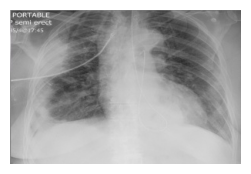

In [74]:
view_random_image(target_dir=Chest_train,target_class='COVID-19')

## Lets visualize the distribution of the training data 🔍

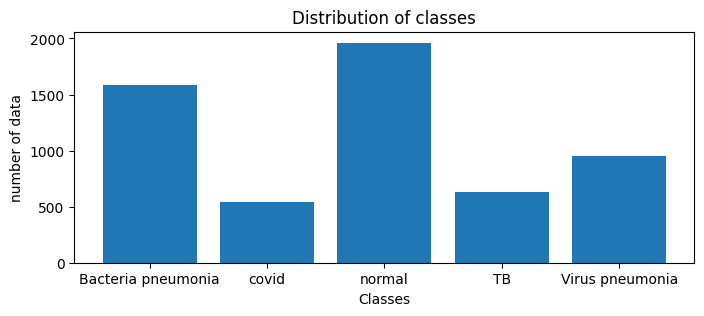

In [75]:

# getting length of the sub classes
BAC_n=len(os.listdir('/content/drive/MyDrive/Chest/Bacteria pneumonia'))
COVID=len(os.listdir('/content/drive/MyDrive/Chest/COVID-19'))
Normal=len(os.listdir('/content/drive/MyDrive/Chest/NORMAL'))
TB=len(os.listdir('/content/drive/MyDrive/Chest/Tuberculosis'))
virus_n=len(os.listdir('/content/drive/MyDrive/Chest/Virus pneumonia'))

classes=['Bacteria pneumonia', "covid",'normal','TB','Virus pneumonia']
values=[BAC_n,COVID,Normal,TB,virus_n]

fig = plt.figure(figsize=(8, 3))  # Set the width and height of the figure

plt.bar(classes,values)
 
# Adding title to the plot
plt.title("Distribution of classes")
 
# Adding label on the y-axis
plt.ylabel('number of data')
 
# Adding label on the x-axis
plt.xlabel('Classes')

plt.show()

## Pre-processing ⚙

In [92]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# recaling pixels 
train_data_gen = ImageDataGenerator(rescale=1./255)

# dividing into batches and  
train_generator = train_data_gen.flow_from_directory(
    Chest_train,
    target_size=(224,224), #targeted shape
    batch_size=32, #32  images per batch
    class_mode='categorical' # we are working with multiclass problem
)


# recaling pixels 
test_data_gen = ImageDataGenerator(rescale=1./255
                                                              )

# dividing into batches and  
test_generator = train_data_gen.flow_from_directory(
    Chest_test,
    target_size=(224, 224), #targeted shape
    batch_size=32, #32  images per batch
    class_mode='categorical' # we are working with multiclass problem
)

Found 5669 images belonging to 5 classes.
Found 1395 images belonging to 5 classes.


In [77]:
import os

# Specify the path to the directory you want to list subdirectories for
directory_path = '/content/drive/MyDrive/Chest-Test'

# Use the os.listdir() function to get a list of all items (files and directories) in the specified directory
items = os.listdir(directory_path)

# Iterate over the items and check if they are directories
subdirectories = []
for item in items:
    item_path = os.path.join(directory_path, item)
    if os.path.isdir(item_path):
        subdirectories.append(item)

# Print the list of subdirectories
print(subdirectories)


['Tuberculosis', 'COVID-19', 'NORMAL', 'Bacteria pneumonia', 'Virus pneumonia']


> we got 5669 images divided into 5 sub-classes for training 

> 1395 images divided into 5 sub-classes for testing

> total image [training+test]= 7064

run below cell if u wanna see numeric representation

In [93]:
train_generator[0]

(array([[[[0.627451  , 0.627451  , 0.627451  ],
          [0.56078434, 0.56078434, 0.56078434],
          [0.41176474, 0.41176474, 0.41176474],
          ...,
          [0.7803922 , 0.7803922 , 0.7803922 ],
          [0.7960785 , 0.7960785 , 0.7960785 ],
          [0.80392164, 0.80392164, 0.80392164]],
 
         [[0.27058825, 0.27058825, 0.27058825],
          [0.1254902 , 0.1254902 , 0.1254902 ],
          [0.11764707, 0.11764707, 0.11764707],
          ...,
          [0.75294125, 0.75294125, 0.75294125],
          [0.7686275 , 0.7686275 , 0.7686275 ],
          [0.8000001 , 0.8000001 , 0.8000001 ]],
 
         [[0.10196079, 0.10196079, 0.10196079],
          [0.12941177, 0.12941177, 0.12941177],
          [0.14901961, 0.14901961, 0.14901961],
          ...,
          [0.7607844 , 0.7607844 , 0.7607844 ],
          [0.79215693, 0.79215693, 0.79215693],
          [0.8235295 , 0.8235295 , 0.8235295 ]],
 
         ...,
 
         [[0.08235294, 0.08235294, 0.08235294],
          [0.06666

## **Lets step into modeling 🕺**

In [94]:
import tensorflow as tf
from tensorflow.keras.layers import Dense,Flatten,Conv2D,MaxPool2D, Activation
from tensorflow.keras.optimizers import Adam,RMSprop
from tensorflow.keras import Sequential


tf.random.set_seed(42) #why 42? because it is Answer to the Ultimate Question of Life, the Universe, and Everything if you know you know 

Model_1=Sequential([
    Conv2D(32,3,activation='relu', input_shape=(200,300,3)),  #3 is kernal size 
    MaxPool2D(),
    Conv2D(10, 3, activation='relu'),
    MaxPool2D(),
    Conv2D(10, 3, activation='relu'),
    MaxPool2D(),
    Flatten(),
    Dense(5, activation='softmax') # softmax as we are working with multiclass problem
])


In [80]:
Model_1.compile(loss='categorical_crossentropy', # as we got multiple classes
                            optimizer=tf.keras.optimizers.RMSprop(), # for now lets dont specify the learning rate,  default is 0.001 and we will also try Rmspromp 
                            metrics=['accuracy'])# evaluation 


In [81]:
history=Model_1.fit(train_generator, 
                   epochs=10,
                    steps_per_epoch=len(train_generator ), 
                   validation_data=(test_generator),
                   validation_steps=len(test_generator ))

Epoch 1/10
178/178 [==============================] - 38s 183ms/step - loss: 0.9956 - accuracy: 0.5878 - val_loss: 0.7232 - val_accuracy: 0.7018
Epoch 2/10
178/178 [==============================] - 31s 174ms/step - loss: 0.6673 - accuracy: 0.7396 - val_loss: 0.5420 - val_accuracy: 0.7785
Epoch 3/10
178/178 [==============================] - 26s 145ms/step - loss: 0.5578 - accuracy: 0.7804 - val_loss: 0.5945 - val_accuracy: 0.7713
Epoch 4/10
178/178 [==============================] - 27s 149ms/step - loss: 0.4934 - accuracy: 0.8042 - val_loss: 0.4707 - val_accuracy: 0.7986
Epoch 5/10
178/178 [==============================] - 26s 144ms/step - loss: 0.4390 - accuracy: 0.8307 - val_loss: 0.5300 - val_accuracy: 0.7842
Epoch 6/10
178/178 [==============================] - 25s 139ms/step - loss: 0.4022 - accuracy: 0.8460 - val_loss: 0.4686 - val_accuracy: 0.7935
Epoch 7/10
178/178 [==============================] - 25s 138ms/step - loss: 0.3597 - accuracy: 0.8633 - val_loss: 0.4750 - val_ac

> accuracy with RMSprop() us 83% for 10 epoch lets check adam()

## helperfunction for plotting loss curves 📉

In [82]:
import pandas as pd
def plot_loss_curves(hist):
    pd.DataFrame(hist.history).plot(figsize=(5,5))

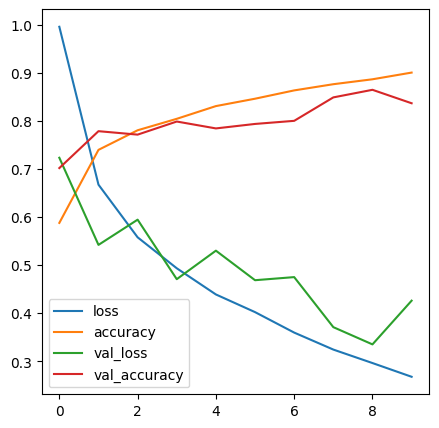

In [83]:
plot_loss_curves(history)

## Adam V/S RMSprop 🤜

In [84]:
tf.random.set_seed(42)

Model_2=Sequential([
    Conv2D(32,3,activation='relu', input_shape=(200,300,3)),  #3 is kernal size 
    MaxPool2D(),
    Conv2D(10, 3, activation='relu'),
    MaxPool2D(),
    Conv2D(10, 3, activation='relu'),
    MaxPool2D(),
    Flatten(),
    Dense(5, activation='softmax') # softmax as we are working with multiclass problem
])
Model_2.compile(loss='categorical_crossentropy', # as we got multiple classes
                            optimizer=tf.keras.optimizers.Adam(), # for now lets dont specify the learning rate,  default is 0.001 and we will also try Rmspromp 
                            metrics=['accuracy'])# evaluation 

history_2=Model_2.fit(train_generator, 
                   epochs=10,
                    steps_per_epoch=len(train_generator ), 
                   validation_data=(test_generator),
                   validation_steps=len(test_generator ))

Epoch 1/10
178/178 [==============================] - 27s 140ms/step - loss: 0.8403 - accuracy: 0.6645 - val_loss: 0.5774 - val_accuracy: 0.7728
Epoch 2/10
178/178 [==============================] - 25s 139ms/step - loss: 0.5443 - accuracy: 0.7887 - val_loss: 0.4779 - val_accuracy: 0.8043
Epoch 3/10
178/178 [==============================] - 24s 137ms/step - loss: 0.5042 - accuracy: 0.8067 - val_loss: 0.6031 - val_accuracy: 0.7706
Epoch 4/10
178/178 [==============================] - 26s 146ms/step - loss: 0.4073 - accuracy: 0.8397 - val_loss: 0.6206 - val_accuracy: 0.7699
Epoch 5/10
178/178 [==============================] - 28s 155ms/step - loss: 0.3675 - accuracy: 0.8614 - val_loss: 0.4635 - val_accuracy: 0.8194
Epoch 6/10
178/178 [==============================] - 24s 134ms/step - loss: 0.3232 - accuracy: 0.8751 - val_loss: 0.4240 - val_accuracy: 0.8251
Epoch 7/10
178/178 [==============================] - 23s 129ms/step - loss: 0.2633 - accuracy: 0.8987 - val_loss: 0.3573 - val_ac

>  we are getting 86% accuracy with adam with same model architecture 

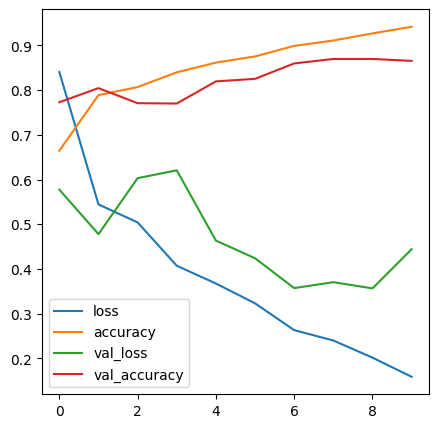

In [85]:
plot_loss_curves(history_2)

# Brain MRI Classification 🧠

In [86]:
Brain_train='/content/drive/MyDrive/Brain_multiclass/Training/'
Brain_test='/content/drive/MyDrive/Brain_multiclass/Testing/'

img shape:(512, 512)


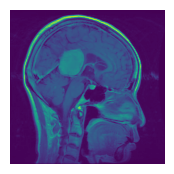

In [87]:
view_random_image(target_dir=Brain_train,target_class='meningioma')

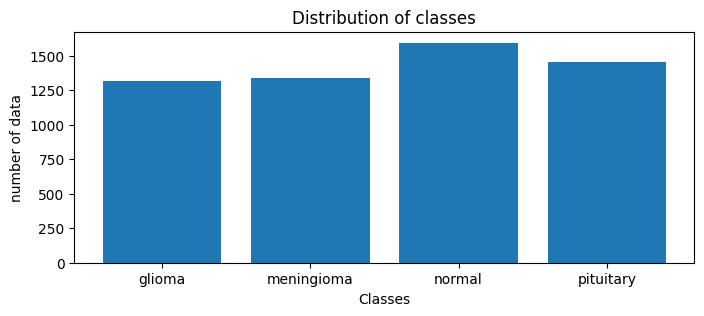

In [88]:

# getting length of the sub classes
gol=len(os.listdir('/content/drive/MyDrive/Brain_multiclass/Training/glioma'))
men=len(os.listdir('/content/drive/MyDrive/Brain_multiclass/Training/meningioma'))
Normal=len(os.listdir('/content/drive/MyDrive/Brain_multiclass/Training/notumor'))
pit=len(os.listdir('/content/drive/MyDrive/Brain_multiclass/Training/pituitary'))

classes=['glioma', "meningioma",'normal','pituitary']
values=[gol,men,Normal,pit]

fig = plt.figure(figsize=(8, 3))  # Set the width and height of the figure

plt.bar(classes,values)
 
# Adding title to the plot
plt.title("Distribution of classes")
 
# Adding label on the y-axis
plt.ylabel('number of data')
 
# Adding label on the x-axis
plt.xlabel('Classes')

plt.show()

In [89]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# recaling pixels 
train_data_gen = ImageDataGenerator(rescale=1./255)

# dividing into batches and  
train_generator = train_data_gen.flow_from_directory(
    Brain_train,
    target_size=(512, 512), #targeted shape
    batch_size=32, #32  images per batch
    class_mode='categorical' # we are working with multiclass problem
)


# recaling pixels 
test_data_gen = ImageDataGenerator(rescale=1./255)

# dividing into batches and  
test_generator = train_data_gen.flow_from_directory(
    Brain_test,
    target_size=(512, 512), #targeted shape
    batch_size=32, #32  images per batch
    class_mode='categorical' # we are working with multiclass problem
)

Found 5712 images belonging to 4 classes.
Found 1316 images belonging to 4 classes.


In [90]:
train_generator[0] 

(array([[[[0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ],
          ...,
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ]],
 
         [[0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ],
          ...,
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ]],
 
         [[0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ],
          ...,
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ]],
 
         ...,
 
         [[0.        , 0.        , 0.        ],
          [0.     